In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb 
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import cv2
%load_ext autoreload
%autoreload 2
import os,sys
import lime
from lime import lime_image, lime_text
from lime.wrappers.scikit_image import SegmentationAlgorithm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

First, we have to fetch the dataset. The official name for the mnist digits set is 'mnist_784'. We can fetch it using the fetch_openml function of sklearn.datasets.

In [2]:
# fetch the data set
mnist = fetch_openml('mnist_784', version=1, cache=True)

Now we have to reshape our data to fit our needs. We will reshape the images to 28x28 pixels and get all data under the correct data type. The images and labels are connected by their indexes.

In [3]:
# reshape images to 28x28, then get labels
images = np.stack([iimg for iimg in mnist.data.values.reshape((-1, 28, 28))],0)
labels = mnist.target.astype(np.uint8)
# images and labels are connected by their indexes

Let's see an example of an image and its corresponding label.

Text(0.5, 1.0, 'Digit: 5')

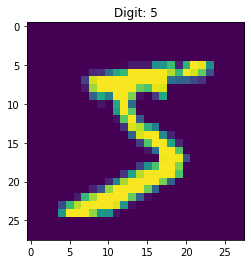

In [4]:
%matplotlib inline
fig, ax1 = plt.subplots(1, 1)
ax1.imshow(images[0], interpolation='none')
ax1.set_title('Digit: {}'.format(labels[0]))

As recommended in one of the LIME tutorials, we will use a pipeline to classify our data. This will symply run all the given lambdas on the given data in order.

We need to turn our images to black and white and the flatten the data in order to feed it into the RandomForestClassifier, then classify it. 

Our pipeline:

In [5]:
class PipeStep(object): # https://github.com/marcotcr/lime/
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

# we change the images to black and white
makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
# flatten images from 28x28 to 746
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])
# the model
random_forest_classifier = RandomForestClassifier()
# our final work flow
pipeline = Pipeline([
    ('Greify', makegray_step),
    ('Flatten', flatten_step),
    ('Random Forest Classifier', random_forest_classifier)
])

Before we train the model we need to split our data in a train set and a test set. We'll keep 75% of the set for training.

In [6]:
# we split the daya into train and test sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.75)
print('Shape of train set: \timages {} \tlabels {}'.format(images_train.shape, labels_train.shape))
print('Shape of test set: \timages {} \tlabels {}'.format(images_test.shape, labels_test.shape))

Shape of train set: 	images (52500, 28, 28) 	labels (52500,)
Shape of test set: 	images (17500, 28, 28) 	labels (17500,)


Running the pipeline, meaning we train our model.

In [7]:
pipeline.fit(images_train, labels_train)

Pipeline(steps=[('Greify', <__main__.PipeStep object at 0x000002D855A57B48>),
                ('Flatten', <__main__.PipeStep object at 0x000002D855A57E08>),
                ('Random Forest Classifier', RandomForestClassifier())])

Let's now run the model on the test set as well and see what's the model's accuracy as the percentage of the correctly classified images.

In [8]:
predictions_test = pipeline.predict(images_test)
accuracy = accuracy_score(labels_test, predictions_test)
print('The model\'s accuracy on the test set is {}'.format(accuracy))

The model's accuracy on the test set is 0.9693714285714286


We can also take a look at the accuracy using a confusion matrix. This shows us on the horizontal what was predicted and on the vertical what should have been predicted as number of times.

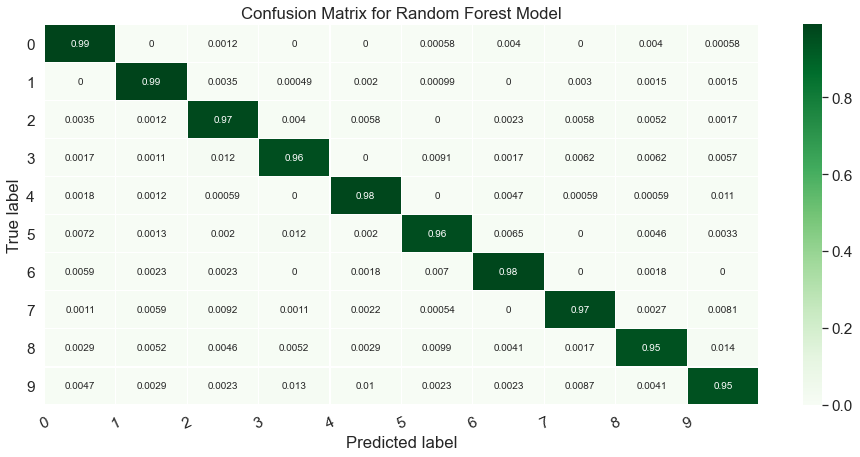

In [9]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(labels_test, predictions_test)
matrix = matrix / matrix.sum(axis=1)[:, np.newaxis]
confusion_matrix(labels_test, predictions_test)
# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

Now we need an explainer instance to explain all the images for us. 

In [10]:
# initialize the explainer 
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

Let's run it on the first image only first as an example. 

In [11]:
# run it on the first image as an example
explanation = explainer.explain_instance(images_test[0], 
                                         classifier_fn = pipeline.predict_proba, 
                                         top_labels=100, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

Before we get the data for the explainer, if we select a random label from the set, the explainer might throw a KeyError if it happens to not be a processed label yet. 
One of the possible solutions is to have the label set taken directly from the explanation, so that the available labels are definitely processed.

In [12]:
# get valid labels; otherwise random indexes might give keyerror
labels_safe = list(explanation.local_exp.keys())
labels_safe.reverse()

Finally, let's show our explanation for an image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Positive/Negative Regions for 6')

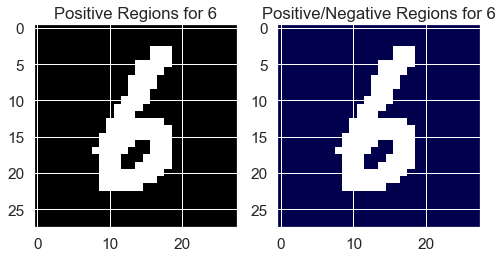

In [13]:
temp, mask = explanation.get_image_and_mask(labels_safe[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(labels_safe[0]))
temp, mask = explanation.get_image_and_mask(labels_safe[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(labels_safe[0]))

We can see here that the black background of the image is a negative region, which means it didn't affect the prediction. The white part is the positive region, so it was the driving part of the prediction, which makes sense since it's the digit itself. 

Finally, let's get the explanations for the whole test data set.
A positive (+) region is the part of the image that affects the prediction. A negative (-) region is the part that doesn't. 
The P number is the predicted value, while the A number is the actual value. 

GitHub has a size limit of 25MB per file so the output cannot be uploaded in full. If you want the full output, just remove lines 4-5.

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


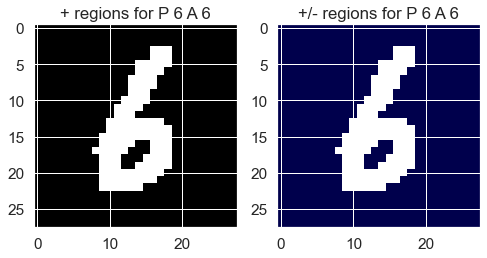

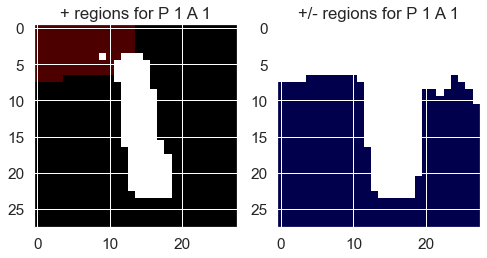

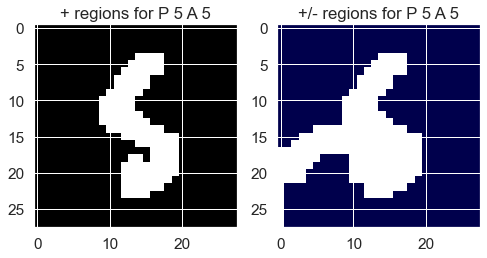

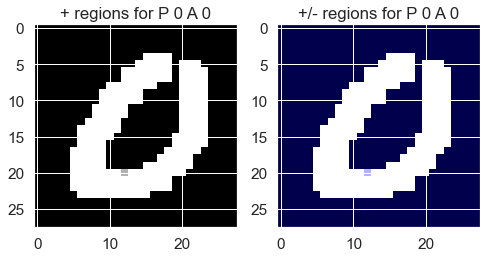

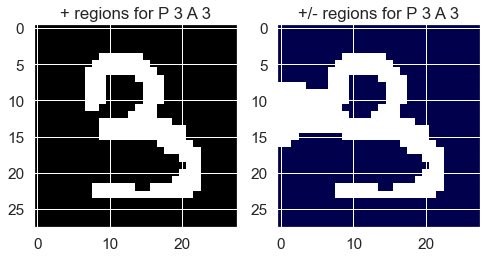

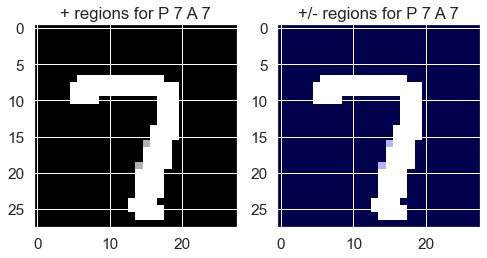

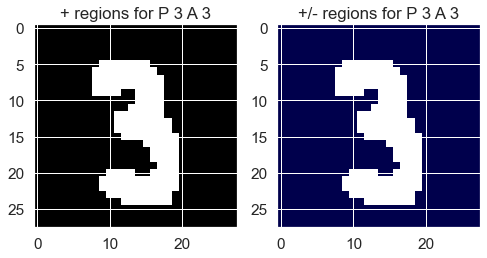

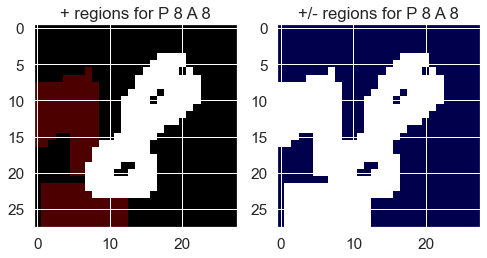

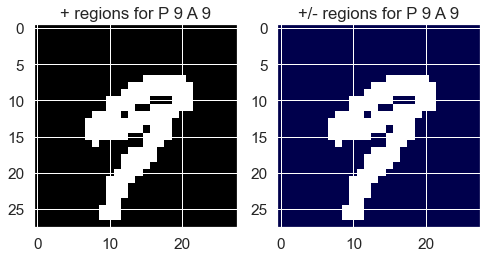

In [14]:
i = 0
for img in images_test:
    i += 1
    if i == 10:
        break
    
    explanation = explainer.explain_instance(img, classifier_fn=pipeline.predict_proba, top_labels=100, hide_color=0, segmentation_fn=segmenter)
    
    labels_safe = list(explanation.local_exp.keys())
    labels_safe.reverse()
    predicted_value = pipeline.predict([img])[0]
    actual_value = labels_safe[0]
    
    temp, mask = explanation.get_image_and_mask(labels_safe[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax1.set_title('+ regions for P {} A {}'.format(predicted_value, labels_safe[0]))
    temp, mask = explanation.get_image_and_mask(labels_safe[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
    ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax2.set_title('+/- regions for P {} A {}'.format(predicted_value, labels_safe[0]))
    